In [838]:
import matplotlib.pyplot as plt
import autograd as ag
import autograd.numpy as np
import scipy.linalg as la
import scipy.signal as sp
import scipy.stats as st
import scipy.integrate as itg
%matplotlib inline

In [863]:
#Assume initial is 
x0=np.array([-1.41,-1.3,-7.02389097])
#Assume a driver does 5 moves 
n_u=5
#u=(np.random.rand(n_u,2)-np.array([0,0.5]))* np.array([2,1])
u=2*np.array([[1.49609465,0.24219884],[0.92401463,0.45875257],[0.10876148,0.43543185],[1.97321445,0.46318528],[0.49352292,0.38270178]])
#u=np.array([[1.49609465,0.24219884],
#            [0.92401463,0.45875257],
#            [0.10876148,0.43543185],
#            [1.97321445,0.46318528],
#            [0.49352292,0.38270178]])

#set every move is equal to 20 unit time
num=20
U=np.repeat(u, 20, axis=0)
#add noise
total=n_u*num
Wp=0.0001 * np.random.randn(total, 3)
#print(U)

In [864]:
SensorLocs=np.array([[0,0]])
tempX1=np.array([-7,-5,-1,1,5,7,])
tempX2=np.array([-8,-4,-2,2,4,8])
tempY1=np.sqrt(3)*np.array([-5,-3,-1,1,3,5])
tempY2=np.sqrt(3)*np.array([-4,-2,0,2,4])
X1, Y1=np.meshgrid(tempX1, tempY1)
X2, Y2=np.meshgrid(tempX2, tempY2)
for i,P1 in enumerate(X1):
    for j,P2 in enumerate(P1):
        SensorLocs=np.append(SensorLocs,np.array([[P2,Y1[i][j]]]),axis=0)
for i,P1 in enumerate(X2):
    for j,P2 in enumerate(P1):
        SensorLocs=np.append(SensorLocs,np.array([[P2,Y2[i][j]]]),axis=0)
    
SensorLocs=np.delete(SensorLocs, 0, 0)
#print(X)
#print(SensorLocs)

In [865]:
x = np.copy(x0)
X_list = [x]
def vectorField(x,u):
    px,py,theta = x
    v,omega = u

    return np.array([v*np.cos(theta),v*np.sin(theta),omega])

def step(x,u,w):
    return x + 0.1 * vectorField(x,u) + w

for u,w in zip(U,Wp):
    x = step(x,u,w)
    X_list.append(x)

X = np.array(X_list)


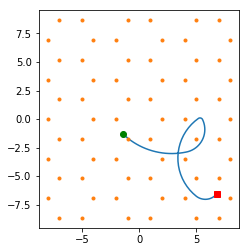

In [866]:
plt.plot(X[:,0],X[:,1])
plt.plot(X[0,0],X[0,1],'go')
plt.plot(X[-1,0],X[-1,1],'rs')
plt.plot(SensorLocs[:,0],SensorLocs[:,1],'.')
plt.gca().set_aspect('equal')

In [867]:
def dot(*mats):
    if len(mats) == 1:
        return mats[0]
    else:
        return np.dot(mats[0],dot(*mats[1:]))

In [868]:
def carTimeUpdate(x,P,u):
    w =np.zeros(3)

    x_next = step(x,u,w)
    
    F = dfdx(x,u,w)
    L = dfdw(x,u,w)

    Q = 0.0001 * np.eye(3)
    P_next = dot(F,P,F.T) + dot(L,Q,L.T)

    return x_next,P_next

In [869]:
def carMeasUpdate(x,P,y):
    v = np.zeros_like(y)
    H = dhdx(x,v)
    G = dhdv(x,v)
    print(H)
    print(G)
    Psi = dot(H,P,H.T) + dot(G,G.T)

    print(Psi)
    K = np.linalg.solve(Psi,np.dot(H,P)).T

    h = measure(x,v)
    x_next = x + np.dot(K,y-h)
    P_next = P - dot(K,Psi,K.T)

    return x_next,P_next

In [870]:

def measure(x,v):
    d = np.linalg.norm(New_sensor-np.outer(np.ones(nSensors),x[:2]),axis=1)
    y = d + noiseStd * (1+d)*v
    return y

In [871]:
noiseStd = 0.2

In [872]:
dfdx = ag.jacobian(step,0)
dfdw = ag.jacobian(step,2)



dhdx = ag.jacobian(measure,0)
dhdv = ag.jacobian(measure,1)


#Y_Pre=np.zeros((len(X),len(SensorLocs)))
#for i in range(len(X)):
#    Y_Pre[i,:]=la.norm(X[i,:2]-SensorLocs,axis=1)

#Y=np.delete(Y_Pre,np.where(Y>4))
#Y=Y_Pre   
#mu = -1.8*np.ones(3)
mu = np.array([-0.1,-0.1,-1.1])
P = 10 * np.eye(3)

Mu_list = []
P_list = []
list1 = []
list2 = []
for k in range(len(X)):
    
    x=mu
    
    
    y_pre=la.norm(X[k,:2]-SensorLocs,axis=1)
    y=np.delete(np.array(y_pre),np.where(y_pre>4),None)
    list1.append([np.where(y_pre>4)])
    list2.append([np.where(y_pre<=4)])
    New_sensor=np.delete(np.array(SensorLocs),np.where(y_pre>4),0)
    nSensors = len(New_sensor)
    
    v = np.zeros_like(y)
    H = dhdx(x,v)
    G = dhdv(x,v)
    #print(h)
    Psi = dot(H,P,H.T) + np.dot(G,G.T)

    K = np.linalg.solve(Psi,np.dot(H,P)).T

    h = measure(x,v)
    mu = x + np.dot(K,y-h)
    P = P - dot(K,Psi,K.T)
    
    
    #print(y.shape)
    Mu_list.append(mu)
    P_list.append(P)

    if k < len(U):
        mu,P = carTimeUpdate(mu,P,U[k])



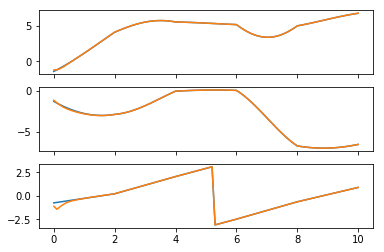

In [873]:
Mu = np.array(Mu_list)
P_arr = np.array(P_list)
#print(Mu)
fig,ax = plt.subplots(3,1,sharex=True)
Time = 0.1 * np.arange(len(X))
ax[0].plot(Time,X[:,0])
ax[0].plot(Time,Mu[:,0])
ax[1].plot(Time,X[:,1])
ax[1].plot(Time,Mu[:,1])

shiftAngle = lambda theta : ((theta + np.pi) % (2*np.pi)) -np.pi

ax[2].plot(Time,shiftAngle(X[:,2]))
ax[2].plot(Time,shiftAngle(Mu[:,2]))

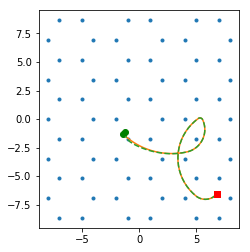

In [874]:
plt.plot(SensorLocs[:,0],SensorLocs[:,1],'.')
plt.plot(X[:,0],X[:,1])
plt.plot(X[0,0],X[0,1],'go')
plt.plot(X[-1,0],X[-1,1],'rs')
plt.plot(Mu[:,0],Mu[:,1],'--')
plt.plot(Mu[0,0],Mu[0,1],'go')
plt.plot(Mu[-1,0],Mu[-1,1],'rs')
plt.gca().set_aspect('equal')

In [875]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np



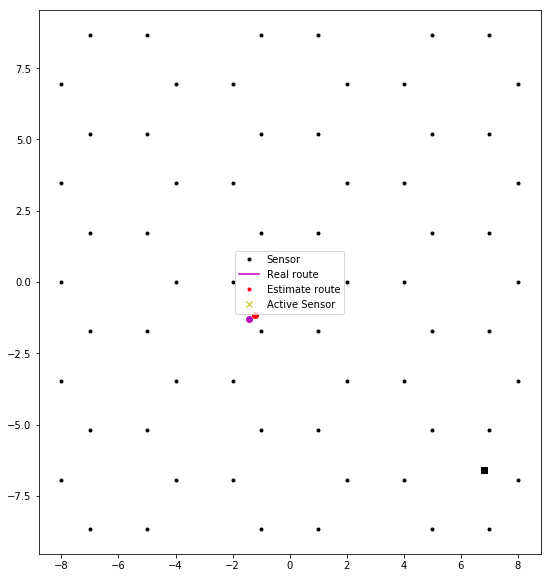

In [876]:
t = Time
x0 = X[:,0]
x1 = X[:,1]
Mu0 = Mu[:,0]
Mu1 = Mu[:,1]

fig, ax = plt.subplots(figsize=(20,10))

plt.plot(SensorLocs[:,0],SensorLocs[:,1],'k.',label='Sensor')
plt.plot(X[0,0],X[0,1],'mo')
plt.plot(X[-1,0],X[-1,1],'rs')
plt.plot(Mu[0,0],Mu[0,1],'ro')
plt.plot(Mu[-1,0],Mu[-1,1],'ks')
plt.gca().set_aspect('equal')


#ax.axis([-2.5,4.5,-0.5,5.5])
L, = ax.plot([],[],'m',label='Real route')
M, = ax.plot([],[],'r.',label='Estimate route')
Point,=ax.plot([],[],'yx',label='Active Sensor')
ax.legend()

In [877]:
def animate(i):
    L.set_data(x0[:i], x1[:i])
    M.set_data(Mu0[:i], Mu1[:i])
    Sensor_open=np.array(list2[i][0][0])
    oo=SensorLocs[Sensor_open]
    Point.set_data(oo[:,0], oo[:,1])
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())

In [878]:
HTML(ani.to_html5_video())